In [1]:
!which python
!python --version

/usr/local/bin/python
Python 3.10.12


# Mask R-CNN

Code and visualizations to test, debug and evaluate the Mask R-CNN model.

We start the model with a weights file that has been trained on the COCO dataset.
The COCO dataset does not contain C Eelegans, but a lot of other images, so that the weights have learned a lot of features already.
It would be possible to train a model from scratch but this is out of scope fpr this project.

In [2]:
!sudo apt-get install python3.7

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package python3.7 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Package 'python3.7' has no installation candidate


In [3]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1

update-alternatives: error: alternative path /usr/bin/python3.7 doesn't exist


In [4]:
!python --version

Python 3.10.12


In [5]:
!sudo apt-get update
!sudo apt-get install python3.7 python3.7-distutils
!wget https://bootstrap.pypa.io/pip/3.7/get-pip.py
!python3.7 get-pip.py

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,566 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,499 kB]
Hit:14 https://ppa.launchpadconten

In [5]:
!python -m pip install tensorflow==2.13.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 4.4 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: keras
    Found existing 

In [6]:
!pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [7]:
# Confirm that GPU is available
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [9]:
# Confirm access to data in Google Drive
!ls /content/gdrive/MyDrive/mrcnn/
!ls /content/gdrive/MyDrive/dataset/


CElegansConfig.py   cElegans.py  __init__.py	    model.py	       __pycache__  visualize.py
CElegansDataset.py  config.py	 mask_rcnn_coco.h5  parallel_model.py  utils.py
train  val


In [10]:
# import mrcnn code
import sys

sys.path.append('/content/gdrive/MyDrive/')

In [11]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [12]:
# root directory of the project
ROOT_DIR = '/content/gdrive/MyDrive/'

import mrcnn.utils
import mrcnn.visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import mrcnn.CElegansDataset

%matplotlib inline

COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mrcnn/mask_rcnn_coco.h5")

In [13]:
from mrcnn.cElegans import CElegansConfig
config = CElegansConfig()
CELEGANS_DIR = os.path.join(ROOT_DIR, "dataset")

In [14]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

### Notebook Preferences

In [15]:
# Device to load the neural network on.
# Useful if you're training a model on the same
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [16]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Load Training Dataset

In [19]:
from mrcnn.cElegans import CElegansDataset

# Load Training dataset
dataset = CElegansDataset()
dataset.load_c_elegans(CELEGANS_DIR, "train")
dataset.prepare()

# Load validation dataset
datatset_val = CElegansDataset()
datatset_val.load_c_elegans(CELEGANS_DIR, "val")
datatset_val.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))
print("Images: {}\nClasses: {}".format(len(datatset_val.image_ids), datatset_val.class_names))

Images: 214
Classes: ['BG', 'c_elegans']
Images: 215
Classes: ['BG', 'c_elegans']


## Load Model

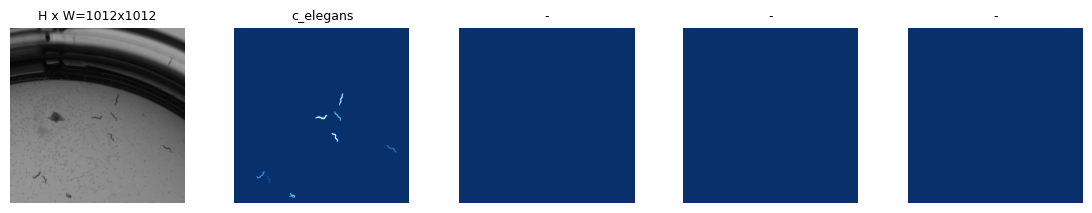

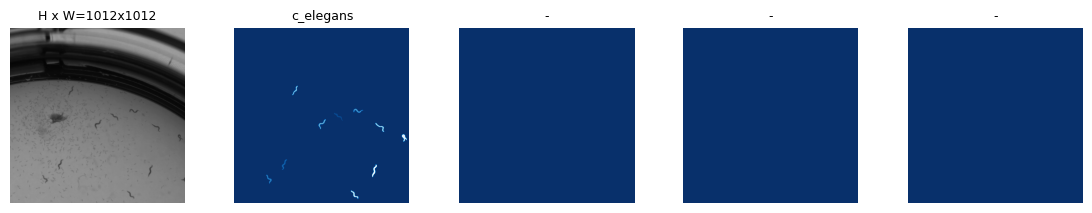

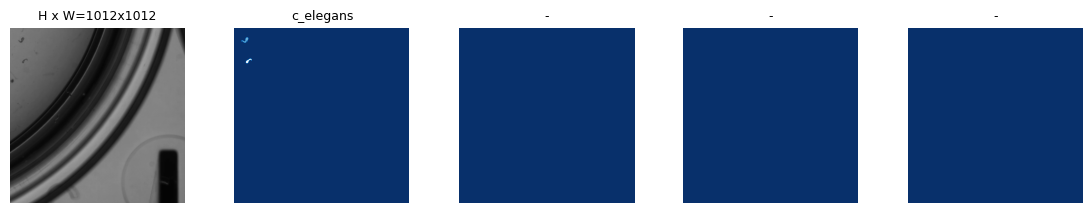

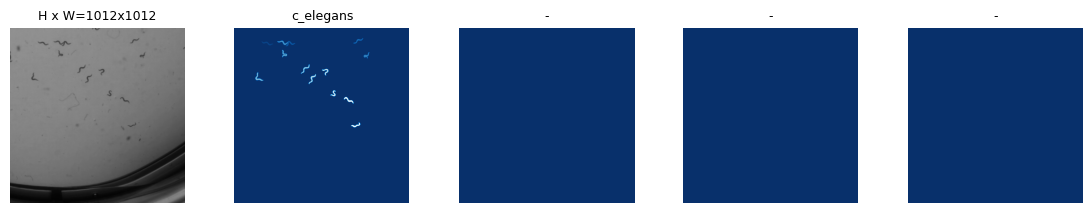

In [20]:
from mrcnn import visualize
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

In [21]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [22]:
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mrcnn/mask_rcnn_coco.h5")

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [23]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset, datatset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=1,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/gdrive/MyDrive/logs/c_elegans20240905T0839/mask_rcnn_c_elegans_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_de

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


100/100 [==============================] - ETA: 0s - batch: 49.5000 - size: 1.0000 - loss: 4.5051 - rpn_class_loss: 0.3029 - rpn_bbox_loss: 2.5877 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 1.2290 - mrcnn_mask_loss: 0.3170

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


100/100 [==============================] - 978s 10s/step - batch: 49.5000 - size: 1.0000 - loss: 4.5051 - rpn_class_loss: 0.3029 - rpn_bbox_loss: 2.5877 - mrcnn_class_loss: 0.0683 - mrcnn_bbox_loss: 1.2290 - mrcnn_mask_loss: 0.3170 - val_loss: 9.5991 - val_rpn_class_loss: 3.0892 - val_rpn_bbox_loss: 3.6373 - val_mrcnn_class_loss: 0.0120 - val_mrcnn_bbox_loss: 2.5041 - val_mrcnn_mask_loss: 0.3564


In [24]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset, datatset_val,
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2,
            layers="all")


Starting at epoch 1. LR=0.0001

Checkpoint Path: /content/gdrive/MyDrive/logs/c_elegans20240905T0839/mask_rcnn_c_elegans_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

In [25]:
# Speichere die trainierten Gewichte
model_path = os.path.join(ROOT_DIR, "mrcnn/mask_rcnn_custom.h5")
model.keras_model.save_weights(model_path)

### Run Detection

In [26]:
class InferenceConfig(CElegansConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mrcnn/mask_rcnn_custom.h5")

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
Use fn_output_signature instead


Loading weights from  /content/gdrive/MyDrive/mrcnn/mask_rcnn_custom.h5


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  159.00000  uint8
image_meta               shape: (14,)                 min:    1.00000  max: 1024.00000  int64
gt_class_id              shape: (3,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (3, 4)                min:   20.00000  max:  346.00000  int32
gt_mask                  shape: (1024, 1024, 3)       min:    0.00000  max:    1.00000  bool


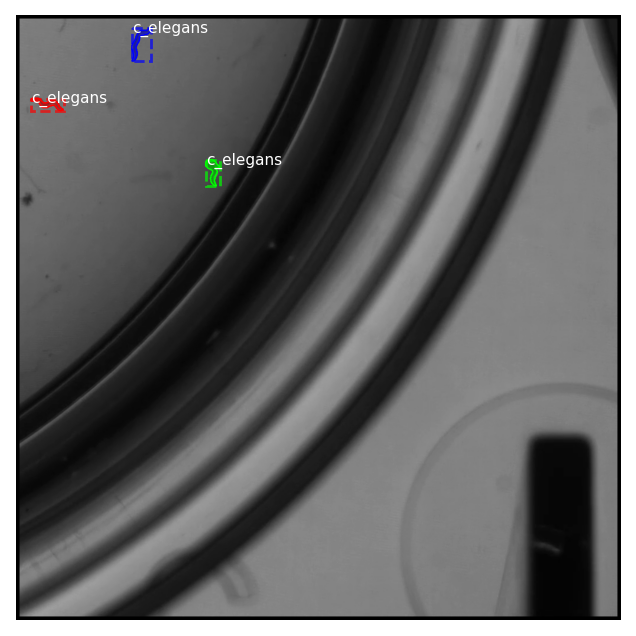

In [34]:
# Test on a random image
image_id = random.choice(datatset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(datatset_val, inference_config,
                           image_id)
mask = mrcnn.utils.expand_mask(gt_bbox, gt_mask, original_image.shape)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", mask)

visualize.display_instances(original_image, gt_bbox, mask, gt_class_id,
                            dataset.class_names, figsize=(8, 8))